In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

sns.set_theme("paper")
sns.set_style("whitegrid")

In [2]:
import os

DATA_DIR = "/home/ubuntu/data"

corona_ann = sc.read_h5ad(os.path.join(DATA_DIR, "COVAC_corrected_annotated.h5ad"))

In [3]:
# manually build ordinal annotation
corona_ann.obs["ordinal_label"] = corona_ann.obs.timepoint.replace({"t1": 0, "t2": 1, "t3": 2, "t4": 3,
                                                                        "d1": 0, "d28": 1, "d56": 2, "M6": 3}).astype("int8")

corona_ann.obs.ordinal_label

new_index
AAACCCACAAGCCCAC-59    2
AAACCCATCTTGTTAC-59    2
AAACGAAAGACAACTA-59    2
AAACGAACATGGGTTT-59    2
AAACGCTTCACTCGAA-59    2
                      ..
TTTGTTGTCGGCCTTT-42    1
TTTGTTGTCGGTAGAG-42    1
TTTGTTGTCGTGGACC-42    1
TTTGTTGTCTATCGGA-42    1
TTTGTTGTCTGTTGGA-42    1
Name: ordinal_label, Length: 398598, dtype: int8

## Filter bad samples

In [4]:
# eliminate Samples 
corona_ann = corona_ann[~corona_ann.obs.sampleID.isin(["58", "30", "31", "32", "29", "20", "21", "60", "44"])]
corona_ann.obs.sampleID.unique()

array([59, 46, 43, 54, 20, 53, 34, 44, 10, 17, 48, 21, 61,  6, 40, 49, 62,
        9, 39, 37, 29, 60, 63, 24, 30, 38, 45,  4, 41, 56, 33,  5,  2, 58,
       36, 31, 55,  1, 47,  3, 50, 35, 32, 57, 11, 42])

In [5]:
cd4 = ["naive CD4+ T", "CD4+ Treg", "CD4+ T"]
cd8 = ["CD8+ T", "naive CD8+ T"]
t_cells = cd4 + cd8
b_cells = ["B", "Plasma"]

## Run PyPsupertime

In [39]:
# TESTRUN WITH REALY HUGE NUMBER OF BATCHES
from pypsupertime import Psupertime

# Psupertime parameters
regularization_params = {"scoring": "accuracy", "n_jobs": 5, "reg_low": 0.001, "reg_high": 0.25, "n_params": 30}
estimator_params = {"penalty": "l1", "min_iter": 50, "n_iter_no_change": 20, "max_iter": 500}
preprocessing_params = {"select_genes": "hvg", "log": False, "normalize": False, "scale": True, "smooth": False}

psuper_test = Psupertime(n_batches=100,
               regularization_params=regularization_params, 
               estimator_params=estimator_params,
               preprocessing_params=preprocessing_params)
test_anndata = psuper_test.run(corona_ann[corona_ann.obs.cell_type.isin(cd4)].copy(), "ordinal_label")

Input Data: n_genes=18910, n_cells=177032
Preprocessing: done. mode='hvg', n_genes=2605, n_cells=177032
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.418619.02, n_genes=11
Total elapsed time:  8:20:12.978492


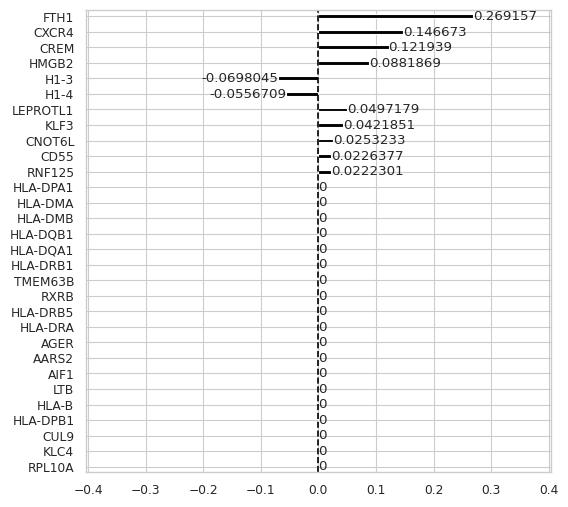

In [40]:
f = psuper_test.plot_identified_gene_coefficients(test_anndata)

### Run on CD4+ in both cohorts

In [35]:
from pypsupertime import Psupertime

# Psupertime parameters
regularization_params = {"scoring": "accuracy", "n_jobs": 5, "reg_low": 0.001, "reg_high": 0.25, "n_params": 30}
estimator_params = {"penalty": "l1", "min_iter": 75, "n_iter_no_change": 20, "max_iter": 500}
preprocessing_params = {"select_genes": "hvg", "log": False, "normalize": False, "scale": True, "smooth": False}

psuper_p_cd4 = Psupertime(n_batches=10,
               regularization_params=regularization_params, 
               estimator_params=estimator_params,
               preprocessing_params=preprocessing_params)
cohort_p_cd4 = psuper_p_cd4.run(corona_ann[corona_ann.obs.cell_type.isin(cd4)].copy(), "ordinal_label")

Input Data: n_genes=18910, n_cells=177032
Preprocessing: done. mode='hvg', n_genes=2605, n_cells=177032
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.421398.02, n_genes=14
Total elapsed time:  13:24:28.823051


Best idx: 25 Best Score: 0.42612085917483133 Best Lambda: 0.0021416591154710435 Scores std: 0.037720285278691194
1SE idx: 10 1SE Score: 0.4051581454920381 1SE Lambda: 0.037244671112900675


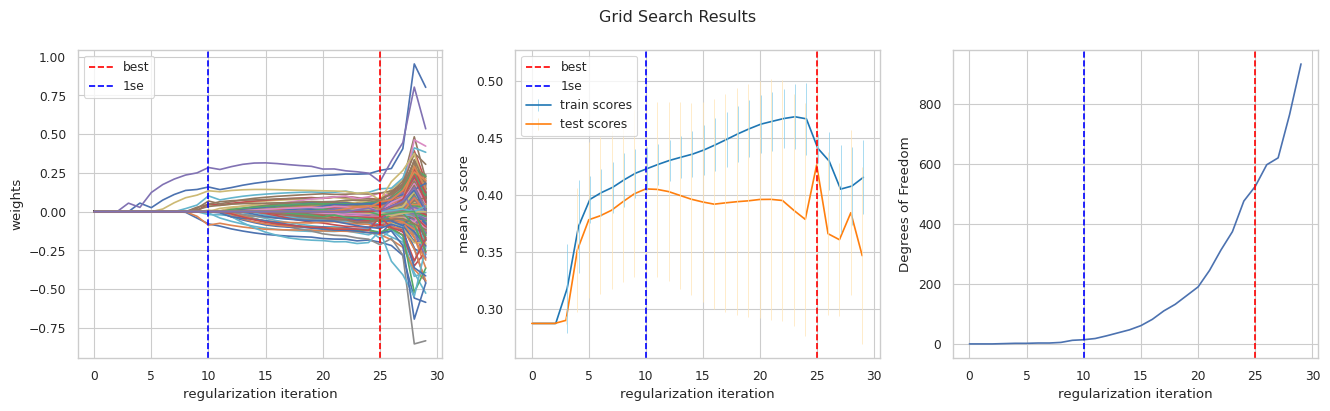

In [36]:
f = psuper_p_cd4.plot_grid_search()
f.savefig("allcohorts_cd4_gridsearch_v2.png")

In [12]:
psuper_p_cd4.refit_and_predict(cohort_p_cd4, "index", 21)

Input Data: n_genes=9825, n_cells=177032
Refit on all data: done. accuracy=0.471937.02, n_genes=471


Model Degrees of freedom 14
Accuracy: 0.4213983912512992
Balanced accuracy: 0.38212775688953027
Mean absolute delta: 1.0154431666449166


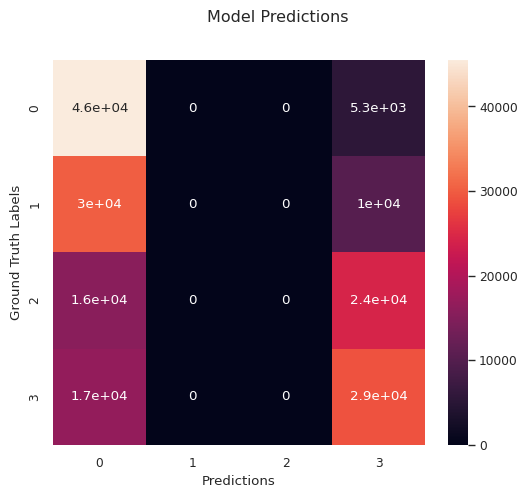

In [37]:
f = psuper_p_cd4.plot_model_perf(train=(cohort_p_cd4.X, cohort_p_cd4.obs.ordinal_label), figsize=(6,5))
f.savefig("allcohorts_cd4_predictions_v2.png")

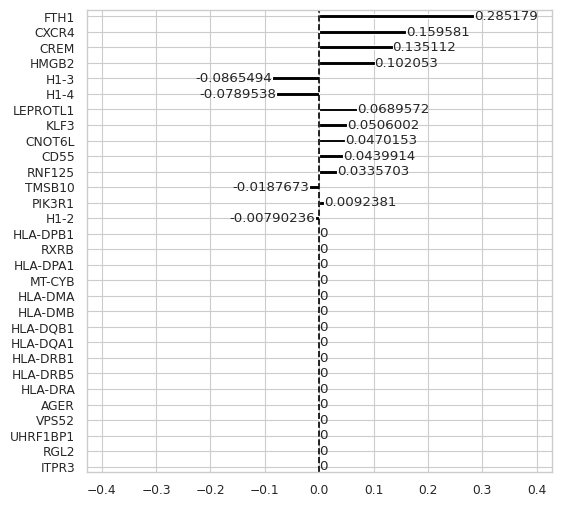

In [38]:
f = psuper_p_cd4.plot_identified_gene_coefficients(cohort_p_cd4)
f.savefig("allcohorts_cd4_genes_v2.png")

### Inspect Expression of Selected Genes over Pseudotime

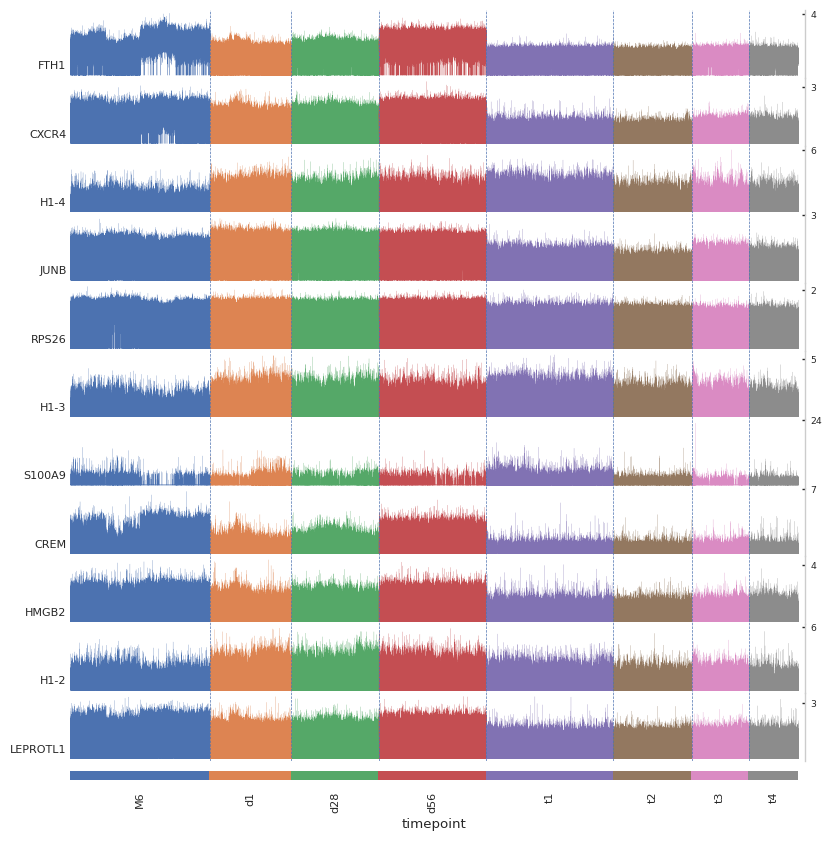

In [22]:
cohort_p_cd4.obs.predicted_label = cohort_p_cd4.obs.predicted_label.astype("category")

sc.pl.tracksplot(cohort_p_cd4[cohort_p_cd4.obs.psupertime.sort_values().index], 
                 var_names=["FTH1", "CXCR4", "H1-4", "JUNB", "RPS26", "H1-3", "S100A9", "CREM", "HMGB2", "H1-2", "LEPROTL1"],
                 groupby="timepoint",
                 categories_order=["d1", "d28", "d56", "M6"],
                 figsize=(10,10)
                )

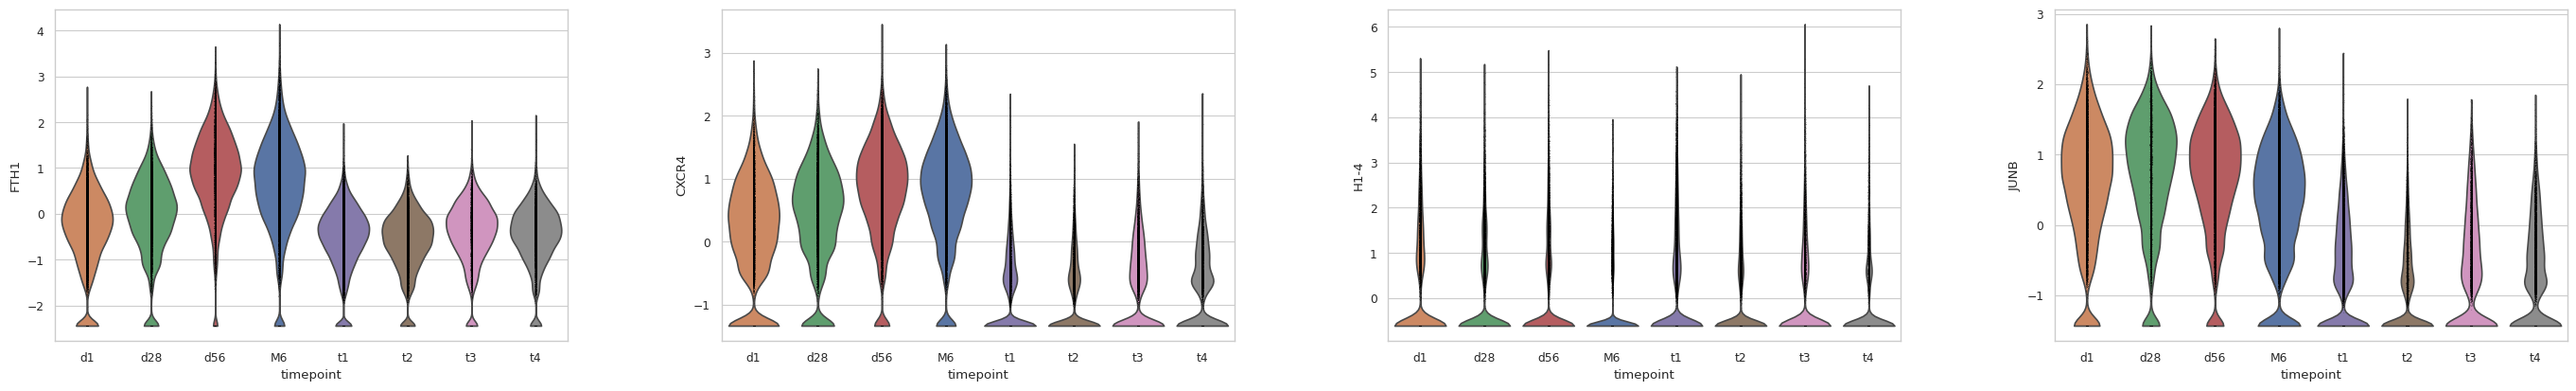

In [34]:
# Top 4 Genes
sc.pl.violin(cohort_p_cd4,
             keys=["FTH1", "CXCR4", "H1-4", "JUNB"],
             groupby="timepoint",
             order=["d1", "d28", "d56", "M6", "t1", "t2", "t3", "t4"],
             jitter=0.015, size=0.25,
             log=False)

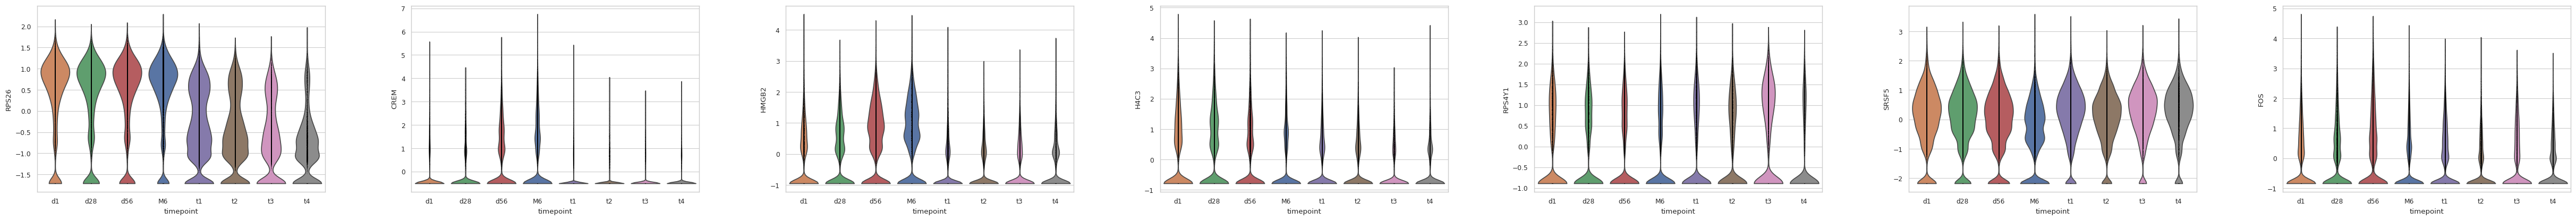

In [33]:
sc.pl.violin(cohort_p_cd4,
             keys=["RPS26", "CREM", "HMGB2", "H4C3", "RPS4Y1", "SRSF5", "FOS"],
             groupby="timepoint",
             order=["d1", "d28", "d56", "M6", "t1", "t2", "t3", "t4"],
             jitter=0.01, size=0.25,
             log=False)

In [15]:
import seaborn as sns

df = pd.DataFrame.from_dict({"psupertime": cohort_p_bcells.obs.psupertime,
                             "expression": cohort_p_bcells[:, cohort_p_bcells.var_names == "MS4A1"].X.flatten()})

df.sort_values("psupertime")
#sns.lineplot(df.sort_values("psupertime"), x="psupertime", y="expression")

,psupertime,expression
new_index,,
CTCCAACGTCGGTACC-29,-4.363403,0.592653
ATTGTTCGTTGCACGC-29,-4.241561,0.554511
TTACCGCGTTGCGGAA-29,-4.201379,0.655394
GTCCACTAGGTTGCCC-29,-4.201249,0.996153
GTAGAGGCAAGGATGC-29,-4.148691,0.515545
...,...,...
TCTTGCGAGTGCTCGC-40,4.546758,0.533260
GGTGAAGGTACGTTCA-40,4.749570,1.329231
TCCTCCCGTTCTGAGT-32,4.787941,-0.142760


In [80]:
genes = cohort_p_bcells.var.psupertime_weight.abs().sort_values(ascending=False)
genes.to_csv("cohort_p_bcells_genes.csv", sep=",")